In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from dhdrnet.util import DATA_DIR, ROOT_DIR

print(DATA_DIR)

/home/shane/Development/DHDRNet/data


In [2]:
from dhdrnet.Dataset import RCDataset

from torchvision.transforms import (
    Compose,
    Resize,
    ToTensor,
)

test_data = RCDataset(
    df=pd.read_csv(ROOT_DIR / "precomputed_data" / "store_current.csv"),
    exposure_path=DATA_DIR / "correct_exposures" / "exposures",
    raw_dir=DATA_DIR / "dngs",
    name_list=ROOT_DIR / "precomputed_data" / "test_current.csv",
    transform=Compose([Resize((300, 300)), ToTensor()]),
)
test_data.data

metric                            mse                                         \
ev                              -3.00        -2.75        -2.50        -2.25   
0006_20160721_170707_736  1564.444742  1620.747432  1666.827206  1694.827552   
0006_20160721_175239_909  4833.678364  4931.049788  5023.474798  5096.684604   
0006_20160721_181525_062  4030.755679  4099.319882  4154.594938  4191.564140   
0006_20160722_100126_028  3096.586446  3195.740610  3285.280822  3355.353795   
0006_20160722_100951_201   256.802163   291.744275   325.948450   357.335873   
...                               ...          ...          ...          ...   
c483_20150901_173210_443   396.788974   414.150080   424.499389   421.893856   
c483_20150901_194029_165  4089.551454  4099.503758  4076.524716  4038.705294   
c483_20150901_195108_436  3136.258062  3158.604146  3150.862320  3122.928498   
c483_20150901_214630_530  5143.751095  5265.341578  5354.983200  5412.049453   
c483_20150901_221141_886  7165.308185  7285.930914  7377.103449  7451.839310   

metric                                                                        \
ev                              -2.00        -1.75        -1.50        -1.25   
0006_20160721_170707_736  1703.434451  1598.156467  1594.859254  1543.512098   
0006_20160721_175239_909  5149.722950  5132.641241  5127.621899  5039.689928   
0006_20160721_181525_062  4196.336224  4112.124243  4107.827877  4003.839777   
0006_20160722_100126_028  3393.217263  3398.260426  3304.577579  3260.788758   
0006_20160722_100951_201   380.441056   381.866729   382.741421   353.604755   
...                               ...          ...          ...          ...   
c483_20150901_173210_443   407.417568   341.777813   338.061688   290.665286   
c483_20150901_194029_165  3962.634683  3856.468872  3444.100464  3442.939489   
c483_20150901_195108_436  3074.531499  2977.176778  2857.079921  2593.799426   
c483_20150901_214630_530  5419.047871  5384.352295  5297.645468  5154.911430   
c483_20150901_221141_886  7482.942462  7485.706860  7433.829155  7331.016986   

metric                                              ...      ssim            \
ev                              -1.00        -0.75  ...      3.75      4.00   
0006_20160721_170707_736  1416.238552  1255.256251  ...  0.959734  0.953911   
0006_20160721_175239_909  4886.487238  4668.281993  ...  0.957424  0.949567   
0006_20160721_181525_062  3848.204339  3646.137740  ...  0.969495  0.965626   
0006_20160722_100126_028  3106.662492  2886.394583  ...  0.963612  0.955471   
0006_20160722_100951_201   303.291687   235.769308  ...  0.975440  0.975728   
...                               ...          ...  ...       ...       ...   
c483_20150901_173210_443   244.182324   212.416530  ...  0.957310  0.956473   
c483_20150901_194029_165  3363.027961  3164.719363  ...  0.971709  0.973337   
c483_20150901_195108_436  2534.649179  2345.410856  ...  0.962358  0.950379   
c483_20150901_214630_530  4959.021309  4355.826203  ...  0.954547  0.946708   
c483_20150901_221141_886  7160.985082  6919.238193  ...  0.939660  0.934590   

metric                                                                      \
ev                            4.25      4.50      4.75      5.00      5.25   
0006_20160721_170707_736  0.947888  0.942444  0.938234  0.935391  0.933572   
0006_20160721_175239_909  0.937777  0.920994  0.899950  0.878370  0.858490   
0006_20160721_181525_062  0.960337  0.953310  0.942647  0.928551  0.910231   
0006_20160722_100126_028  0.945895  0.935127  0.923266  0.910170  0.896825   
0006_20160722_100951_201  0.975196  0.974106  0.972672  0.971321  0.970290   
...                            ...       ...       ...       ...       ...   
c483_20150901_173210_443  0.956189  0.956502  0.957197  0.958147  0.958975   
c483_20150901_194029_165  0.968661  0.959896  0.948609  0.937562  0.926985   
c483_20150901_195108_436  0.938581  0.930643  0.926860  0.926224  0.920695   
c483_20150901_214630_530  0.9367

In [3]:
import torch.nn.functional as F
import torch

errors = test_data.data["mse"]
err_t = torch.tensor(errors.to_numpy())
emax, _ = err_t.max(dim=1, keepdim=True)
emin, _ = err_t.min(dim=1, keepdim=True)
# err_norm = (err_t - emin) / (emax - emin)
# print(emax.shape)
# print(err_t.shape)
err_inv = emax - err_t
error_probabilities = (err_inv / err_inv.sum(dim=1, keepdim=True)).numpy()

err_df = pd.DataFrame(error_probabilities, index=errors.index, columns=errors.columns)
err_df = pd.concat([err_df, errors], keys=("prob", "mse"))
err_df

ev                                   -3.00        -2.75        -2.50  \
prob 0006_20160721_170707_736     0.003962     0.002357     0.001044   
     0006_20160721_175239_909     0.003076     0.002128     0.001229   
     0006_20160721_181525_062     0.001954     0.001145     0.000493   
     0006_20160722_100126_028     0.004304     0.002890     0.001612   
     0006_20160722_100951_201     0.029990     0.028178     0.026405   
...                                    ...          ...          ...   
mse  c483_20150901_173210_443   396.788974   414.150080   424.499389   
     c483_20150901_194029_165  4089.551454  4099.503758  4076.524716   
     c483_20150901_195108_436  3136.258062  3158.604146  3150.862320   
     c483_20150901_214630_530  5143.751095  5265.341578  5354.983200   
     c483_20150901_221141_886  7165.308185  7285.930914  7377.103449   

ev                                   -2.25        -2.00        -1.75  \
prob 0006_20160721_170707_736     0.000245     0.000000     0.003001   
     0006_20160721_175239_909     0.000516     0.000000     0.000166   
     0006_20160721_181525_062     0.000056     0.000000     0.000994   
     0006_20160722_100126_028     0.000612     0.000072     0.000000   
     0006_20160722_100951_201     0.024777     0.023579     0.023505   
...                                    ...          ...          ...   
mse  c483_20150901_173210_443   421.893856   407.417568   341.777813   
     c483_20150901_194029_165  4038.705294  3962.634683  3856.468872   
     c483_20150901_195108_436  3122.928498  3074.531499  2977.176778   
     c483_20150901_214630_530  5412.049453  5419.047871  5384.352295   
     c483_20150901_221141_886  7451.839310  7482.942462  7485.706860   

ev                                   -1.50        -1.25        -1.00  \
prob 0006_20160721_170707_736     0.003095     0.004559     0.008187   
     0006_20160721_175239_909     0.000215     0.001071     0.002562   
     0006_20160721_181525_062     0.001045     0.002272     0.004109   
     0006_20160722_100126_028     0.001337     0.001961     0.004161   
     0006_20160722_100951_201     0.023460     0.024971     0.027579   
...                                    ...          ...          ...   
mse  c483_20150901_173210_443   338.061688   290.665286   244.182324   
     c483_20150901_194029_165  3444.100464  3442.939489  3363.027961   
     c483_20150901_195108_436  2857.079921  2593.799426  2534.649179   
     c483_20150901_214630_530  5297.645468  5154.911430  4959.021309   
     c483_20150901_221141_886  7433.829155  7331.016986  7160.985082   

ev                                   -0.75  ...        3.75        4.00  \
prob 0006_20160721_170707_736     0.012777  ...    0.042720    0.040976   
     0006_20160721_175239_909     0.004685  ...    0.049166    0.049012   
     0006_20160721_181525_062     0.006494  ...    0.047626    0.047743   
     0006_20160722_100126_028     0.007303  ...    0.046876    0.045750   
     0006_20160722_100951_201     0.031080  ...    0.036685    0.036775   
...                                    ...  ...         ...         ...   
mse  c483_20150901_173210_443   212.416530  ...  491.562211  453.472541   
     c483_20150901_194029_165  3164.719363  ...  423.285114  436.143826   
     c483_20150901_195108_436  2345.410856  ...  710.151501  887.286390   
     c483_20150901_214630_530  4355.826203  ...  223.605843  387.514681   
     c483_20150901_221141_886  6919.238193  ...  115.567154  141.445638   

ev                                   4.25        4.50         4.75  \
prob 0006_20160721_170707_736    0.038788    0.036664     0.034901   
     0006_20160721_175239_909    0.048269    0.046416     0.043465   
     0006_20160721_181525_062    0.047628    0.047221     0.046454   
     0006_20160722_100126_028    0.043899    0.041213     0.037872   
     0006_20160722_100951_201    0.036704    0.036516     0.036200   
...                                   ...         ...          ...   
mse  c483_2015

196
Float64Index([ -3.0, -2.75,  -2.5, -2.25,  -2.0, -1.75,  -1.5, -1.25,  -1.0,
              -0.75,  -0.5, -0.25,  0.25,   0.5,  0.75,   1.0,  1.25,   1.5,
               1.75,   2.0,  2.25,   2.5,  2.75,   3.0,  3.25,   3.5,  3.75,
                4.0,  4.25,   4.5,  4.75,   5.0,  5.25,   5.5,  5.75,   6.0],
             dtype='float64', name='ev')


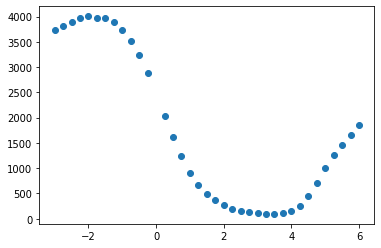

In [4]:
from random import randint
ind = randint(0,len(err_df.loc["prob"]) - 1)
print(ind)
s = err_df.loc["prob"].iloc[ind].transpose()
y = err_df.loc["mse"].iloc[ind].transpose()
x = s.index
print(x)
plt.scatter(x, y) 

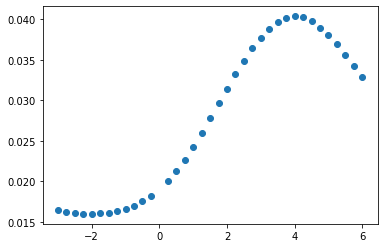

In [5]:
mean_mse = err_df.loc["mse"].aggregate("mean", axis=0).to_numpy()
mse_prob = 1 - (mean_mse / mean_mse.max())
plt.scatter(x=errors.columns, y=F.softmax(torch.tensor(mse_prob),dim=0))

In [6]:
from IPython.utils import io
from pytorch_lightning import Trainer

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
gpus = "0" if torch.cuda.is_available() else None

trainer = Trainer(gpus=gpus, progress_bar_refresh_rate=0)

def load_test_model(ckpt, model_cls):
    model = model_cls.load_from_checkpoint(checkpoint_path=str(ckpt))
    model.eval()

    with io.capture_output(stdout=True, stderr=True) as _captured:
        test_score = trainer.test(model)["test_loss"]
    return test_score, model, ckpt.stem

def get_best_model(model_cls, backbone: str):
    test_scores = dict()
    for ckpt in (ROOT_DIR / "checkpoints").glob(f"*{backbone}*.ckpt"):
        test_scores[str(ckpt.stem)] = load_test_model(ckpt,model_cls)

    best_model = min(test_scores.values(), key=lambda x: x[0])
    return best_model


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


In [14]:
from dhdrnet.reconstruction_model import RCNet
from dhdrnet.histogram_model import HistogramNet
from dhdrnet.model import DHDRMobileNet_v3, DHDRSqueezeNet
from dhdrnet.resnet_model import DHDRResnet
from dhdrnet.Dataset import LUTDataset, RCDataset
from pytorch_lightning import seed_everything


seed_everything(19)
if all(model_name in locals() for model_name in ["rcnet_name", "mobile_name", "resnet_name", "squeeze_name"]):
    print("model names defined")
    rcnet_score, rcnet_model, _ = load_test_model(rc_name, RCNet)
    mobile_score, mobile_model, _  = load_test_model(mobile_name, DHDRMobileNet_v3)
    resnet_score, resnet_model, _ = load_test_model(resnet_name, DHDRResnet)
    squeeze_score, squeeze_model, _ = load_test_model(squeeze_name, DHDRSqueezeNet)
else:
    print("finding best models")
    rcnet_score, rcnet_model, rc_name = get_best_model(RCNet, "reconstruction")
    mobile_score, mobile_model, mobile_name = get_best_model(DHDRMobileNet_v3, "mobile_v3")
    resnet_score, resnet_model, resnet_name = get_best_model(DHDRResnet, "resnet")
    squeeze_score, squeeze_model, squeeze_name = get_best_model(DHDRSqueezeNet, "squeeze")

print(f"{mobile_score=}")
print(f"{resnet_score=}")
print(f"{squeeze_score=}")


finding best models


KeyboardInterrupt: 

In [9]:
from torch.utils.data import DataLoader
from more_itertools import flatten, one, collapse

evs = torch.tensor(test_data.evs)


def get_ev(evs, indices):
    return [evs[i] for i in indices]


def get_rec_predictions(model, batch, k=4):
    X, y_true, names = batch
    y_pred = model(X.to(device))
    _, pred_ev_idx = torch.topk(y_pred, k, dim=1)
    pred_ev = evs[pred_ev_idx]

    true_ev_idx = torch.argmax(y_true, dim=1)
    true_ev = evs[true_ev_idx]
    return zip(names, pred_ev.numpy(), true_ev.numpy())


def get_ce_predictions(model, batch, k=4):
    X, y_true_idx, names = batch
    y_pred = model(X.to(device))
    _, pred_ev_idx = torch.topk(y_pred, k, dim=1)
    pred_ev = evs[pred_ev_idx]

    true_ev = evs[y_true_idx]
    return zip(names, pred_ev.numpy(), true_ev.numpy())


def topk_accuracy(model, evaluator, dataloader, k=4):
    model.eval()
    names, pred_evs, true_evs = zip(
        *flatten((evaluator(model, batch, k) for batch in dataloader))
    )

    c = 0
    for predicted_evs, true_ev in zip(pred_evs, true_evs):
        if true_ev in predicted_evs:
            c += 1

    return 100.0 * c / len(names)


In [11]:
rc_data = test_data
reconstruction_loader = DataLoader(rc_data, batch_size=70, num_workers=8)

# rcnet_model = RCNet.load_from_checkpoint(
#     str(ROOT_DIR / "checkpoints" / "reconstructiondhdr-epoch=173-val_loss=0.00.ckpt")
# ).to(device)

lut_data = LUTDataset(
    df=pd.read_csv(ROOT_DIR / "precomputed_data" / "store_current.csv"),
    exposure_path=DATA_DIR / "correct_exposures" / "exposures",
    raw_dir=DATA_DIR / "dngs",
    name_list=ROOT_DIR / "precomputed_data" / "test_current.csv",
    transform=Compose([Resize((300, 300)), ToTensor()]),
)
lut_loader = DataLoader(lut_data, batch_size=70, num_workers=8)

In [12]:
from collections import defaultdict
from pprint import pprint

model_loader_pairs = {
  "Reconstruction": (rcnet_model,   get_rec_predictions, reconstruction_loader),
  "ResNet-18":      (resnet_model,  get_ce_predictions,  lut_loader),
  "MobileNet-v2":   (mobile_model,  get_ce_predictions,  lut_loader),
  "SqueezeNet":     (squeeze_model, get_ce_predictions,  lut_loader),
}

model_topk_scores = defaultdict(list)

for k in range(1, 8):
    for name, args in model_loader_pairs.items():
        score = topk_accuracy(*args, k=k)
        model_topk_scores[name].append(score)

pprint(model_topk_scores)

defaultdict(<class 'list'>,
            {'MobileNet-v2': [41.850828729281766,
                              66.98895027624309,
                              77.76243093922652,
                              86.60220994475138,
                              90.88397790055248,
                              93.50828729281768,
                              95.1657458563536],
             'Reconstruction': [4.696132596685083,
                                8.287292817679559,
                                13.67403314917127,
                                18.50828729281768,
                                23.204419889502763,
                                29.558011049723756,
                                38.12154696132597],
             'ResNet-18': [44.889502762430936,
                           70.1657458563536,
                           80.8011049723757,
                           86.46408839779005,
                           90.05524861878453,
                           92.541436464

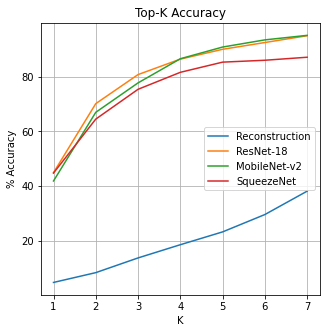

In [37]:
from pathlib import Path
figdir = Path(ROOT_DIR/"figures")
kdf = pd.DataFrame(model_topk_scores, index=range(1,8))
ax = kdf.plot(
    grid="both", 
    title="Top-K Accuracy",
    xlabel="K",
    ylabel="% Accuracy",
    figsize=(5,5)
)
ax.figure.savefig(figdir/"topk_plot.pdf")

In [25]:
kdf.to_latex(figdir/"topk_table.tex")